# Load model and signal processing functions

In [1]:
import pickle as pkl

#Load the data
with open('model.pkl', 'rb') as file:
    pipe, lbenc = pkl.load(file)

In [2]:
#Read audio data from files
#Using ffmpeg

import numpy as np
import subprocess as sp
import librosa

duration = 30

def get_waveform(filename, mono=True, duration=30, delay=0, sr=22050):
    if mono:
        n_channels = 1
    else:
        n_channels = 2 # n_channels: 2 for stereo, 1 for mono
    
    command = [ 'ffmpeg',
            '-i', filename,
            '-f', 's16le',
            '-ss', str(delay),
            '-t', str(duration),
            '-acodec', 'pcm_s16le',
            '-ar', str(sr),
            '-ac', str(n_channels),
            '-']
    proc = sp.run(command, stdout=sp.PIPE, bufsize=duration*sr, stderr=None, check=False) #stderr=sp.DEVNULL
    audio_array = np.fromstring(proc.stdout, dtype="int16")
    
    audio_array = librosa.util.normalize(audio_array)
    
    return audio_array, sr

In [3]:
from librosa.effects import harmonic
from librosa.effects import hpss
from librosa.feature import spectral_contrast
from scipy.stats import skew, kurtosis

#Generate the Feature vector

#Harmonic-Percussive Source Separation
def get_harm(data, n=13):
    y_harm, y_perc = hpss(data)
    return np.concatenate((get_mfcc(y_harm, n), get_mfcc(y_perc, n), get_spect(data)))

#MFCC
def get_mfcc(data, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=n_mfcc, n_fft = 2048, hop_length=512, n_mels=40, power=2.0)
    
    mean = np.mean(mfcc, axis=1)
    var = np.std(mfcc, axis=1)
    
    derv = np.gradient(mfcc, axis=1)
    derv2 = np.gradient(derv, axis=1)
    
    derv_mean = np.mean(derv,axis=1)
    derv_var = np.std(derv,axis=1)
    
    derv2_mean = np.mean(derv2,axis=1)
    derv2_var = np.std(derv2,axis=1)
    
    ret = np.concatenate((mean,var,derv_mean, derv_var, derv2_mean, derv2_var))
    return ret

#Spectral contrast
def get_spect(data):
    spec_cont = spectral_contrast(data)
    
    mean = np.mean(spec_cont,axis=1)
    var = np.std(spec_cont, axis=1)
    
    derv = np.gradient(spec_cont, axis=1)
    derv2 = np.gradient(derv, axis=1)
    
    derv_mean = np.mean(derv,axis=1)
    derv_var = np.std(derv,axis=1)
    
    derv2_mean = np.mean(derv2,axis=1)
    derv2_var = np.std(derv2,axis=1)
    
    ret = np.concatenate((mean,var,derv_mean, derv_var, derv2_mean, derv2_var, \
                          skew(spec_cont, axis=1), kurtosis(spec_cont, axis=1)))
    return ret

# Plot predictions

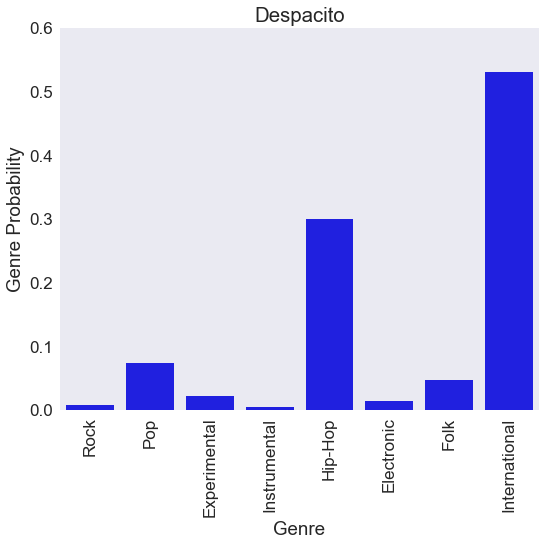

In [5]:
# Get distribution of top genres for a song

filename = 'Despacito.mp3'

tags = {}


delay = 30
a, sr = get_waveform(filename, mono=True, duration=30, delay=delay, sr=22050)
# feed it into the signal processing pipeline to get a feature vector
vec = get_harm(a).reshape(1,-1)

# run predictions on the feature vector
for i, score in enumerate(pipe.predict_proba(vec)[0]):
    tags[lbenc.inverse_transform(i)] = score

vals = sorted([(key, val) for key, val in tags.items()], key=lambda x: x[1], reverse=True)
v1,v2 = zip(*vals)

#Sort values arbitrarily
v1 = ['Rock','Pop','Experimental', 'Instrumental', 'Hip-Hop', 'Electronic','Folk', 'International']
v2 = [tags[i] for i in v1]

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(font_scale=1.7)
sns.set_style(None)

fig = plt.figure(figsize=(8, 8))
g = sns.barplot(x=v1, y=v2, palette=['blue'])
g.set_xticklabels(labels=v1, rotation=90);
g.set_ylabel('Genre Probability')
g.set_xlabel('Genre')
g.set_title('Despacito')
g.grid(False)
plt.ylim([0,0.6])
plt.tight_layout()

#fig.savefig('temp.png', transparent=True)


# Build the frame-by-frame video using a moving window

In [6]:
filename = 'Jenny.mp3'

duration = 30
song_length = 228
step_size = 0.25

k = 0
frames = []

try:
    while True:
        tags = {}

        a, sr = get_waveform(filename, mono=True, duration=duration, delay=k*step_size, sr=22050)
        # feed it into the signal processing pipeline to get a feature vector
        vec = get_harm(a).reshape(1,-1)

        # run predictions on the feature vector
        for i, score in enumerate(pipe.predict_proba(vec)[0]):
            tags[lbenc.inverse_transform(i)] = score

        #vals = sorted([(key, val) for key, val in tags.items()], key=lambda x: x[1], reverse=True)
        #v1,v2 = zip(*vals)

        #Sort values arbitrarily
        v1 = ['Rock','Pop','Experimental', 'Instrumental', 'Hip-Hop', 'Electronic','Folk', 'International']
        v2 = [tags[i] for i in v1]
        frames.append(v2)
        print(k*step_size)
except ValueError:
    pass

0.0
0.25
0.5
0.75
1.0
1.25
1.5
1.75
2.0
2.25
2.5
2.75
3.0
3.25
3.5
3.75
4.0
4.25
4.5
4.75
5.0
5.25
5.5
5.75
6.0
6.25
6.5
6.75
7.0
7.25
7.5
7.75
8.0
8.25
8.5
8.75
9.0
9.25
9.5
9.75
10.0
10.25
10.5
10.75
11.0
11.25
11.5
11.75
12.0
12.25
12.5
12.75
13.0
13.25
13.5
13.75
14.0
14.25
14.5
14.75
15.0
15.25
15.5
15.75
16.0
16.25
16.5
16.75
17.0
17.25
17.5
17.75
18.0
18.25
18.5
18.75
19.0
19.25
19.5
19.75
20.0
20.25
20.5
20.75
21.0
21.25
21.5
21.75
22.0
22.25
22.5
22.75
23.0
23.25
23.5
23.75
24.0
24.25
24.5
24.75
25.0
25.25
25.5
25.75
26.0
26.25
26.5
26.75
27.0
27.25
27.5
27.75
28.0
28.25
28.5
28.75
29.0
29.25
29.5
29.75
30.0
30.25
30.5
30.75
31.0
31.25
31.5
31.75
32.0
32.25
32.5
32.75
33.0
33.25
33.5
33.75
34.0
34.25
34.5
34.75
35.0
35.25
35.5
35.75
36.0
36.25
36.5
36.75
37.0
37.25
37.5
37.75
38.0
38.25
38.5
38.75
39.0
39.25
39.5
39.75
40.0
40.25
40.5
40.75
41.0
41.25
41.5
41.75
42.0
42.25
42.5
42.75
43.0
43.25
43.5
43.75
44.0
44.25
44.5
44.75
45.0
45.25
45.5
45.75
46.0
46.25
46.5
46.75
47.0
4

ValueError: zero-size array to reduction operation maximum which has no identity

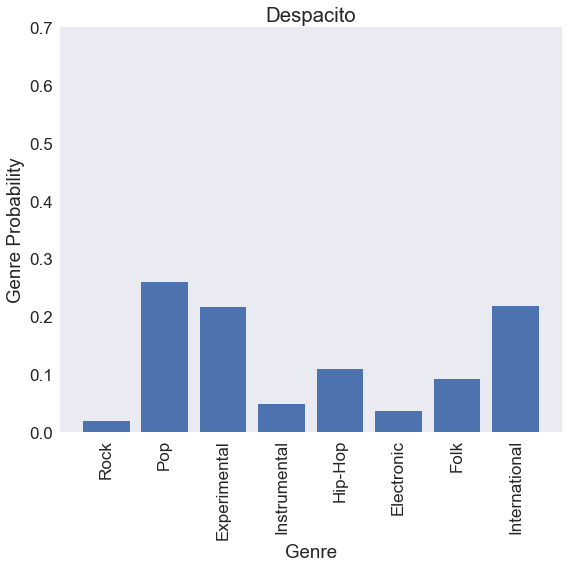

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import animation
%matplotlib inline
#%matplotlib nbagg
# Get distribution of top genres for a song

v1 = ['Rock','Pop','Experimental', 'Instrumental', 'Hip-Hop', 'Electronic','Folk', 'International']

frame_buff = 5

fig = plt.figure(figsize=(8, 8))
barcol = plt.bar(range(8), frames[0])
plt.xticks(range(8), v1, rotation='vertical')
plt.grid(False)
plt.xlabel('Genre')
plt.ylabel('Genre Probability')
plt.title('Despacito')
plt.ylim([0,0.7])
plt.tight_layout()

def animate(i):
    y=frames[i//frame_buff+1]
    for i, b in enumerate(barcol):
        b.set_height(y[i])
    
anim=animation.FuncAnimation(fig,animate, repeat=False,blit=False, frames=(len(frames)-1)*frame_buff,
                             interval=100, save_count=200)

anim.save('mymovie.mp4', fps=frame_buff/step_size)
plt.show()